In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import urllib
import joblib
import pickle
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
URL = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz'

def get_housing_data(url=URL):
    os.mkdir('./dataset')
    urllib.request.urlretrieve(url, 'housing.tgz')
    tgz = tarfile.open('./housing.tgz')
    tgz.extractall('./dataset')
    tgz.close()

get_housing_data()

FileExistsError: [WinError 183] Nie można utworzyć pliku, który już istnieje: './dataset'

In [4]:
def load_housing_data(path='./dataset/housing.csv'):
    return pd.read_csv(path)

In [5]:
housing_df = load_housing_data()

In [6]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

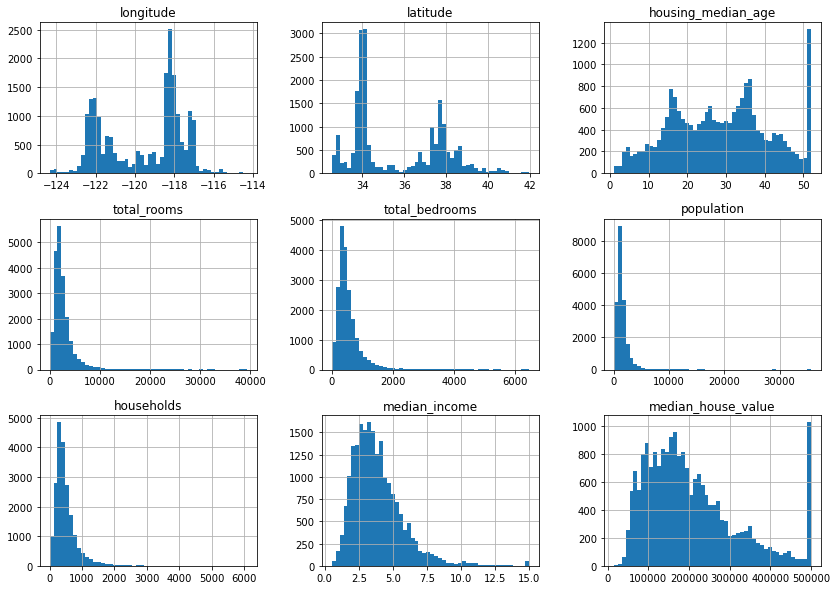

In [8]:
housing_df.hist(bins=50, figsize=(14,10))

In [9]:
housing_df['income_cat'] = pd.cut(housing_df['median_income'], bins=[0., 1.5, 3., 4.5, 6., np.inf,],
                                 labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

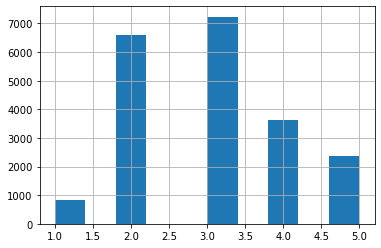

In [10]:
housing_df['income_cat'].hist()

In [96]:
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in train_test_split.split(housing_df, housing_df['income_cat']):
    train_df = housing_df.loc[train_idx]
    test_df = housing_df.loc[test_idx]

In [97]:
train_df.drop('income_cat', axis=1, inplace=True)
test_df.drop('income_cat', axis=1, inplace=True)

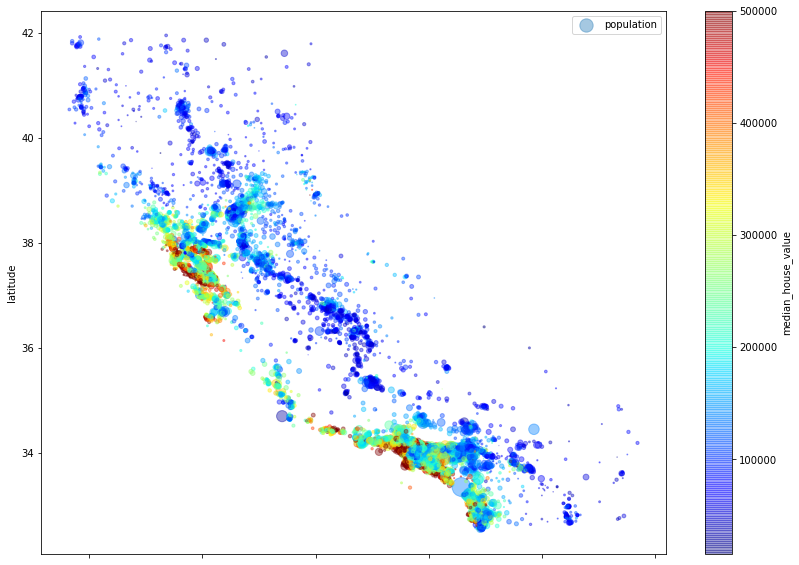

In [13]:
train_df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
              s=train_df['population']/100, label='population', figsize=(14, 10), 
              c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

<AxesSubplot:>

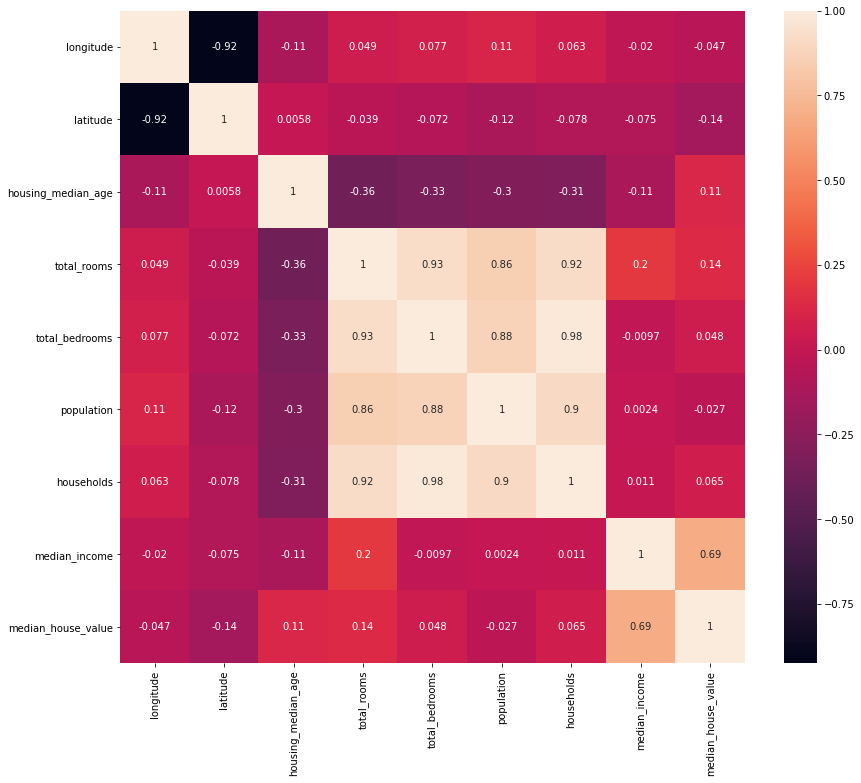

In [14]:
correlations = train_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlations, annot=True)


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

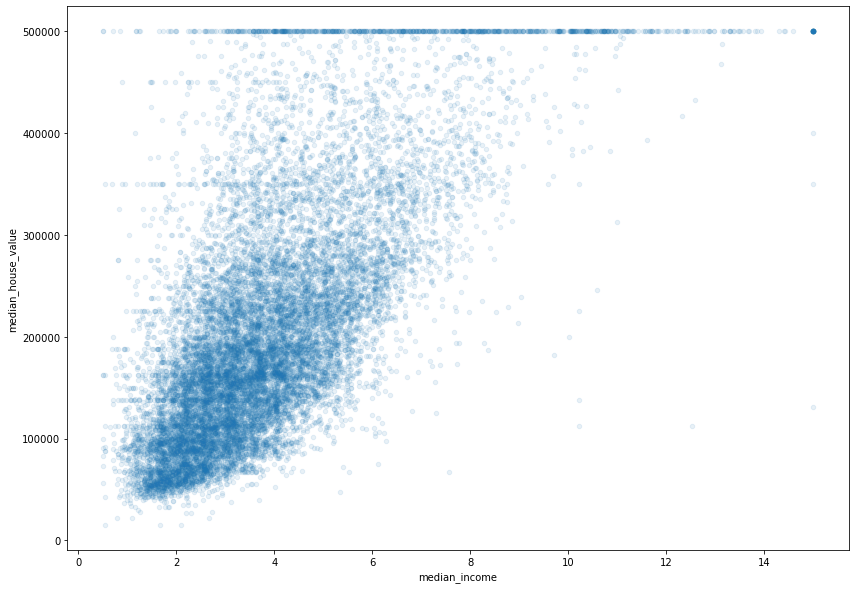

In [15]:
train_df.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, 
              figsize=(14,10))

In [16]:
train_df['rooms_per_household'] = train_df['total_rooms'] / train_df['households']
train_df['bedrooms_per_room'] = train_df['total_bedrooms'] / train_df['total_rooms']
train_df['population_per_household'] = train_df['population'] / train_df['households']

<AxesSubplot:>

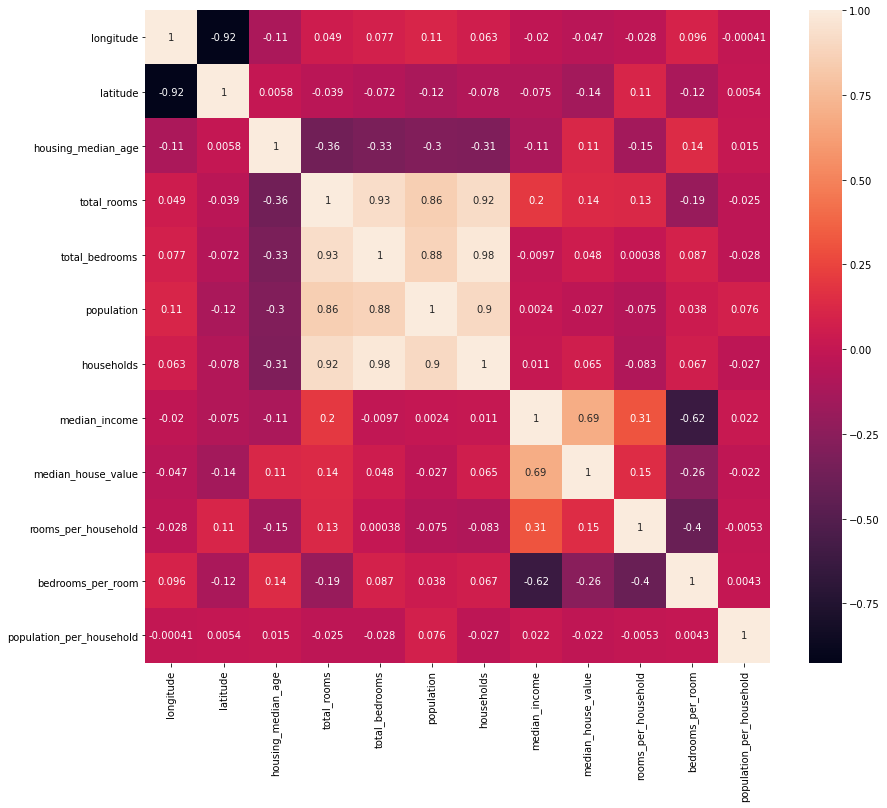

In [17]:
correlations = train_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlations, annot=True)

In [98]:
y_train = train_df['median_house_value'].copy()
X_train = train_df.drop('median_house_value', axis=1)

In [99]:
X_num = X_train.drop('ocean_proximity', axis=1)

In [100]:
rooms_idx = 3
bedrooms_idx = 4
population_idx = 5
households_idx = 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_idx] / X[:, households_idx]
        population_per_household = X[:, population_idx] / X[:, households_idx]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        return np.c_[X, rooms_per_household, population_per_household]

In [101]:
attr_adder = CombinedAttributesAdder()
combined_attributes = attr_adder.transform(train_df.values)

In [42]:
# One-hot encoding
X_train = pd.get_dummies(train_df, columns=['ocean_proximity'])
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,4.625369,0.223852,2.094395,1,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,6.008850,0.159057,2.707965,1,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,4.225108,0.241291,2.025974,0,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,5.232295,0.200866,4.135977,0,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,4.505810,0.231341,3.047847,1,0,0,0,0


In [102]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('attr_adder', CombinedAttributesAdder()),
                         ('scaler', StandardScaler())])

In [103]:
cat_pipeline = Pipeline([('one_hot_encoder', OneHotEncoder())])

In [104]:
num_features = list(X_num)
cat_features = ['ocean_proximity']

pipeline = ColumnTransformer([('num', num_pipeline, num_features),
                              ('cat', cat_pipeline, cat_features)])

X_train = pipeline.fit_transform(X_train)
#X_train = pd.DataFrame(X_train, columns=num_features+cat_features)
X_train

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [64]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [65]:
y_pred = model_lr.predict(X_train)
lr_mse = mean_squared_error(y_train, y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_rmse

68161.22644433199

In [66]:
model_dtr = DecisionTreeRegressor()
model_dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [67]:
y_pred = model_dtr.predict(X_train)
dtr_mse = mean_squared_error(y_train, y_pred)
dtr_rmse = np.sqrt(dtr_mse)
dtr_rmse

0.0

In [68]:
scores = cross_val_score(model_dtr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
dtr_rmse_scores = np.sqrt(-scores)
dtr_rmse_scores

array([69706.86153855, 66365.54759017, 70833.15110436, 68740.47543544,
       69789.81926188, 74691.1907446 , 70498.9339106 , 70929.78340755,
       75669.25957178, 69779.91891563])

In [69]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {np.mean(scores)}')
    print(f'Std: {np.std(scores)}')

In [70]:
display_scores(dtr_rmse_scores)

Scores: [69706.86153855 66365.54759017 70833.15110436 68740.47543544
 69789.81926188 74691.1907446  70498.9339106  70929.78340755
 75669.25957178 69779.91891563]
Mean: 70700.49414805637
Std: 2569.486629788785


In [71]:
lr_scores = cross_val_score(model_lr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
lr_rmse_scores = np.sqrt(-lr_scores)

display_scores(lr_rmse_scores)

Scores: [66060.65470195 66764.30726969 67721.72734022 74719.28193624
 68058.11572078 70909.35812986 64171.66459204 68075.65317717
 71024.84033989 67300.24394751]
Mean: 68480.58471553595
Std: 2845.5843092650834


In [72]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)

RandomForestRegressor()

In [73]:
y_pred = model_rfr.predict(X_train)
rfr_mse = mean_squared_error(y_train, y_pred)
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse

18732.58000642366

In [74]:
rfr_scores = cross_val_score(model_rfr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rfr_rmse_scores = np.sqrt(-rfr_scores)

display_scores(rfr_rmse_scores)

Scores: [49234.29699709 47560.05544843 49019.79405122 52194.64061089
 49368.85313631 53414.83053765 48671.3565404  47860.23058106
 52775.99834552 49995.40963421]
Mean: 50009.546588276935
Std: 1960.2417887088652


In [75]:
joblib.dump(model_rfr, 'model_rfr.pkl')
joblib.dump(rfr_rmse_scores, 'rfr_rmse_scores.pkl')

['rfr_rmse_scores.pkl']

In [3]:
model = joblib.load('model_rfr.pkl')

In [105]:
# Hyperparameters tuning
n_estimators = [40, 50, 60]
max_features = [4, 6, 8]

param_grid = {'n_estimators': n_estimators, 'max_features': max_features}

In [106]:
model_rfr = RandomForestRegressor()

In [107]:
grid_search = GridSearchCV(model_rfr, param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [4, 6, 8],
                         'n_estimators': [40, 50, 60]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [108]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 60}

In [109]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=60)

In [110]:
results = grid_search.cv_results_

for mean, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mean), params)

49870.689371971486 {'max_features': 4, 'n_estimators': 40}
50075.47045126746 {'max_features': 4, 'n_estimators': 50}
49965.40642823267 {'max_features': 4, 'n_estimators': 60}
49885.204766223935 {'max_features': 6, 'n_estimators': 40}
49441.7068066176 {'max_features': 6, 'n_estimators': 50}
49424.24173265039 {'max_features': 6, 'n_estimators': 60}
49961.54090778717 {'max_features': 8, 'n_estimators': 40}
49645.07256908132 {'max_features': 8, 'n_estimators': 50}
49565.72079729806 {'max_features': 8, 'n_estimators': 60}


In [115]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_features = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_encoder = pipeline.named_transformers_['cat'][0]
one_hot_features = list(cat_encoder.categories_[0])
features = num_features + extra_features + one_hot_features
sorted(zip(feature_importances, features), reverse=True)

[(0.3012998430364905, 'median_income'),
 (0.16170297907829193, 'INLAND'),
 (0.10667749145609648, 'population_per_household'),
 (0.10101777563369638, 'bedrooms_per_room'),
 (0.07520115746558968, 'longitude'),
 (0.0702056790650186, 'latitude'),
 (0.055807732312612206, 'rooms_per_household'),
 (0.04136423740853217, 'housing_median_age'),
 (0.017863646085291167, 'total_rooms'),
 (0.01711847216661555, 'population'),
 (0.01676807490096637, 'total_bedrooms'),
 (0.016420646154762856, 'households'),
 (0.011487635512951785, '<1H OCEAN'),
 (0.004592736260193902, 'NEAR OCEAN'),
 (0.0023501170955992166, 'NEAR BAY'),
 (0.000121776367291265, 'ISLAND')]

In [118]:
y_test = test_df['median_house_value'].copy()
X_test = test_df.drop('median_house_value', axis=1)

In [119]:
X_test = pipeline.transform(X_test)

In [114]:
model = grid_search.best_estimator_

In [120]:
y_pred = model.predict(X_test)

In [121]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

47234.43822015062